<a href="https://colab.research.google.com/github/sisrel/EE214-Practice-Materials/blob/main/Practice-Fall2023/%5Bweek%2013%5D%20RNN_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Week 13] Recurrent Neural Network

Long short-term memory (LSTM) RNN was first introduced in the paper [Long Short-Term Memory (Hochreiter and Schmidhuber, 1997)](https://ieeexplore.ieee.org/abstract/document/6795963). In this practice session we will try to solve Task 6a from the paper.

Before we start, let us import some libraries set the seeds for reproducibility.


In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor, nn
from torch.nn.utils.rnn import (
    pack_padded_sequence,
    pad_packed_sequence,
    unpack_sequence,
)
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm, trange

In [2]:
# Comment the first line and uncomment the second line if you want to use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")

SEED = 77

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

RNG = np.random.default_rng(SEED)

np.set_printoptions(precision=3, sign=' ')

## About the Task

The below is an excerpt from the LSTM paper the explains about the task.

> The goal is to classify sequences. Elements and targets are represented locally (input vectors with only one nonzero bit). The sequence starts with an *E*, ends with a *B* (the "trigger symbol"), and otherwise consists of randomly chosen symbols from the set {*a*, *b*, *c*, *d*} except for two elements at positions $t_1$ and $t_2$ that are either *X* or *Y*. The sequence length is randomly chosen between 100 and 110, $t_1$ is randomly chosen between 10 and 20, and $t_2$ is randomly chosen between 50 and 60. There are four sequence classes *Q*, *R*, *S*, *U*, which depends on the temporal order of *X* and *Y*. The rules are: *X*, *X* &rightarrow; *Q*; *X*, *Y* &rightarrow; *R*; *Y*, *X* &rightarrow; *S*; *Y*, *Y* &rightarrow; *U*.

Our first job is to generate data to train our RNN. To make the problem a bit easier, we randomly choose the sequence length between ***70 and 80 (instead of 100 and 110)***.

In [3]:
def generate_data(
    num_samples: int
) -> tuple[NDArray[np.string_], NDArray[np.integer], NDArray[np.string_]]:
    """ Randomly generate data.

    Parameters:
     - num_samples(int): number of samples to generate

    Returns:
    tuple of three NumPy arrays (sequences, lengths, labels)
     - sequences: character NumPy array containing the generated sequences
                  the sequences are padded to their maximum length, 80
     - lengths: integer NumPy array containing the length of each sequence
     - labels: character NumPy array containing the true class labels

    Shape:
     - sequences: (num_samples, 80)
     - lengths: (num_samples,)
     - labels: (num_samples,)
    """
    labels = RNG.choice(["Q", "R", "S", "U"], size=num_samples)
    lengths = RNG.integers(70, 81, size=num_samples)
    t1s = RNG.integers(10, 21, size=num_samples)
    t2s = RNG.integers(50, 61, size=num_samples)
    sequences = RNG.choice(["a", "b", "c", "d"], size=(num_samples, 80))
    sequences[:, 0] = "E"
    sequences[np.arange(num_samples), lengths - 1] = "B"
    # X if Q or R. Y otherwise.
    sequences[np.arange(num_samples), t1s] = np.where(
        np.isin(labels, ["Q", "R"]), "X", "Y"
    )
    # X if Q or S. Y otherwise
    sequences[np.arange(num_samples), t2s] = np.where(
        np.isin(labels, ["Q", "S"]), "X", "Y"
    )
    return sequences, lengths, labels

Let us run the function and see the results.

In [4]:
def print_task(num_samples: int):
    sequences, lengths, labels = generate_data(num_samples)
    for seq, len_, lab in zip(sequences, lengths, labels):
        print(
            f"{lab}:",
            "".join(
                (c if c in "abcdEB" else f"\033[95m{c}\033[0m")
                for c in seq[:len_]
            )
        )

print_task(10)

Q: EbbbbbcacacdbadbbaXbcabacdbaaddbbdbbdccddaccaacbdacdaaXbbabbadddabddababB
U: EddbcdcacadcbbddcdYdddacaddbddbddddaaadbddccbcaccbdbbcadadadYdcacbcbdabddB
S: EabbdbddabbabbcbbbYabdcaccbcbdbcaaaabaccdadacbaaadbcXcbdcdaaadadccabdddaB
S: EcacaaaaccaccabdYdcdaacdcbbdcdbcdcacccdcbdbaddcdacadbbbcdXabdaadbacdbdcbcaccdB
U: EcdddcaaddcbbdcbdccbYccdcdacccabccaddaabbadbabcbdbcYabdcbbcaacddbaadcacB
Q: EbcdbccacccXbdaadbddbdbabdbabbadacdabcabbadbacabcbcXabadddbadacbdbabcB
U: EcaadadddaaaccbdbaYdbaaaabccdddacbcbcbdaddcdcabbddYacdbbababbaabbbdcaadaddcbcbcB
R: EdadcbdaaaadbXccbaacadddddabdbbcbaabdbddddabadaaccabaddbbabYaddabccacacbbB
U: EddaddcbbaaaacccaYcccdacbcabaabcbaacbcaacbbbdbbdbaddYbdddacadbbdcbcdcadB
R: EdababddbddaaddbadbXcddbadddaccacdacbbdacadbdaaddadYcdddbdccabcacbcbdadabcddcB


## Prepare the Data for Training
### Tokenizing and Tensorizing
We now need to convert the character array into a float Tensor. We will use the following scheme.

**Sequences**

| *E* | *B* | *a* | *b* | *c* | *d* | *X* | *Y* |
|-----|-----|-----|-----|-----|-----|-----|-----|
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |

**Labels**

| *Q* | *R* | *S* | *U* |
|-----|-----|-----|-----|
|  0  |  1  |  2  |  3  |


In [5]:
def preprocess(
    sequences: NDArray[np.string_], labels: NDArray[np.string_]
) -> tuple[NDArray[np.integer], NDArray[np.integer]]:
    sequences_ = np.frompyfunc("EBabcdXY".index, 1, 1)(sequences)
    labels_ = np.frompyfunc("QRSUVABC".index, 1, 1)(labels)
    return sequences_.astype(int), labels_.astype(int)

## Create Dataset

For efficient training, it is usually a good idea to create a [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset). Among the various methods that PyTorch provides to create datasets, we will use [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

In [6]:
def create_dataset(num_samples: int) -> TensorDataset:
    sequences, lengths, labels = generate_data(num_samples)
    sequences_, labels_ = preprocess(sequences, labels)
    tensor_sequences = torch.as_tensor(sequences_)
    tensor_lengths = torch.as_tensor(lengths)
    tensor_labels = torch.as_tensor(labels_)
    return TensorDataset(tensor_sequences, tensor_lengths, tensor_labels)

### Handling Variable Lengths

The sequences generated by the tasks have variable length, and thus cannot be stacked as a single batch and feeded into a network. PyTorch provides a useful tool called [`pack_padded_sequence`](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html) that can be used in such cases. This function basically transforms a tensor containing a batch of sequences of different lengths, padded to the length of the longest one, into a [`PackedSequence`](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.PackedSequence.html#torch.nn.utils.rnn.PackedSequence) object. When an RNN module(`nn.RNN`, `nn.LSTM`, `nn.GRU`, etc.) gets a `PackedSequence` object as an input, it will automatically handle the change in sequence length for us. Note that a `PackedSequence` object can be unpacked using the [`unpack_sequence`](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.unpack_sequence.html#torch.nn.utils.rnn.unpack_sequence) function or converted into a padded tensor using the [`pad_packed_sequence`](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html#torch.nn.utils.rnn.pad_packed_sequence) function.

Below, we briefly demonstrate a usage of `pack_padded_sequence` and `unpack_sequence` using a small-sized RNN. [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) returns two tensors when called: a tensor containing the hidden state for each $t$ and for each element in the batch and a tensor containing the final hidden state for each element in the batch. By feeding a `PackedSequence` as input and unpacking the first element of the output, we can check that the second element of the output is indeed the final hidden state for each sequence in the batch.

In [7]:
def test_pack_padded_sequence():
    data = torch.rand((10, 100, 5))
    lengths = list(range(100, 80, -2))
    print("Input Lengths:")
    print(lengths)
    print("")
    sequence = pack_padded_sequence(data, lengths, batch_first=True)
    model = nn.RNN(5, 4, batch_first=True)
    with torch.no_grad():
        outputs, hns = model(sequence)
    unpacked = unpack_sequence(outputs)
    print("Output Lengths:")
    print([seq.size(0) for seq in unpacked])
    print("")
    print('Final hidden state:')
    for seq in unpacked:
        print(seq[-1].numpy())
    print("")
    print("Second element of the output:")
    for seq in hns[0]:
        print(seq.numpy())


test_pack_padded_sequence()

Input Lengths:
[100, 98, 96, 94, 92, 90, 88, 86, 84, 82]

Output Lengths:
[100, 98, 96, 94, 92, 90, 88, 86, 84, 82]

Final hidden state:
[ 0.627 -0.586  0.765  0.834]
[ 0.566 -0.344  0.573  0.796]
[ 0.584 -0.551  0.708  0.825]
[ 0.465 -0.502  0.51   0.741]
[ 0.535 -0.354  0.611  0.742]
[ 0.732 -0.325  0.73   0.86 ]
[ 0.619 -0.511  0.679  0.823]
[ 0.663 -0.532  0.707  0.803]
[ 0.614 -0.336  0.622  0.82 ]
[ 0.396 -0.595  0.694  0.776]

Second element of the output:
[ 0.627 -0.586  0.765  0.834]
[ 0.566 -0.344  0.573  0.796]
[ 0.584 -0.551  0.708  0.825]
[ 0.465 -0.502  0.51   0.741]
[ 0.535 -0.354  0.611  0.742]
[ 0.732 -0.325  0.73   0.86 ]
[ 0.619 -0.511  0.679  0.823]
[ 0.663 -0.532  0.707  0.803]
[ 0.614 -0.336  0.622  0.82 ]
[ 0.396 -0.595  0.694  0.776]


In this project we will use `pad_packed_sequence` instead of `unpack_sequence` as it is computationally much efficient when dealing with multiple sequences. Below is a simple demonstration of how `pad_packed_sequence` works. It returns the padded sequence together with a length tensor. Using the length tensor we can compute the last element for each sequence.

In [8]:
def test_pad_packed_sequence():
    data = torch.rand(5, 10, 1)
    lengths = torch.randint(5, 11, (5,))
    sequences = pack_padded_sequence(
        data, lengths, batch_first=True, enforce_sorted=False
    )
    padded, pad_lengths = pad_packed_sequence(sequences, batch_first=True)
    end_elements = padded[torch.arange(padded.size(0)), pad_lengths - 1]
    print('Sequence')
    for (seq, len_) in zip(data.squeeze(2), lengths):
        print(seq[:len_].numpy())
    print('')
    print('Length')
    print(lengths.numpy())
    print('')
    print('Padded Sequence')
    print(padded.squeeze(2).numpy())
    print('')
    print('Padded Sequence Length')
    print(pad_lengths.numpy())
    print('')
    print('End Elements Computed from Padded Sequence')
    print(end_elements.numpy())


test_pad_packed_sequence()

Sequence
[ 0.185  0.775  0.929  0.607  0.657  0.727]
[ 0.95   0.258  0.922  0.082  0.805  0.206  0.623  0.767  0.924  0.102]
[ 0.447  0.298  0.235  0.296  0.649  0.339  0.738  0.229  0.249]
[ 0.069  0.988  0.388  0.069  0.704  0.99   0.06   0.791  0.789]
[ 0.446  0.879  0.135  0.955  0.451  0.517  0.996  0.424]

Length
[ 6 10  9  9  8]

Padded Sequence
[[ 0.185  0.775  0.929  0.607  0.657  0.727  0.     0.     0.     0.   ]
 [ 0.95   0.258  0.922  0.082  0.805  0.206  0.623  0.767  0.924  0.102]
 [ 0.447  0.298  0.235  0.296  0.649  0.339  0.738  0.229  0.249  0.   ]
 [ 0.069  0.988  0.388  0.069  0.704  0.99   0.06   0.791  0.789  0.   ]
 [ 0.446  0.879  0.135  0.955  0.451  0.517  0.996  0.424  0.     0.   ]]

Padded Sequence Length
[ 6 10  9  9  8]

End Elements Computed from Padded Sequence
[[ 0.727]
 [ 0.102]
 [ 0.249]
 [ 0.789]
 [ 0.424]]


## Create the Character Embedding
We have converted the characters in the input sequences to number, but the scheme was selected arbitrarily. For instance, under our scheme, *a* was converted to 2 and *Y* was converted to 7, but it does not mean that *a* < *Y*. A natural representation would be to use a one-hot embedding. We usually learn the embeddings end-to-end when we are dealing with complex tasks. However, the current task at hand is relatively simple, so a one-hot embedding will suffice.

In [9]:
embedding = nn.Embedding.from_pretrained(
    torch.eye(8, device=DEVICE), freeze=True
)


def test_embedding(sequence: str):
    indices = ["EBabcdXY".index(c) for c in sequence]
    return embedding(torch.as_tensor(indices, device=DEVICE))


print(test_embedding("EcYbadbcXB"))

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')


## Create the Model

It is time to create the model. We will test three kinds of models: RNN, LSTM, and GRU.

### RNN

<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/LSTM3-SimpleRNN.png" width="70%"/>
<br/>
<em>Figure from <a href="https://colah.github.io/about.html">Christopher Olah</a>'s blog <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">post</a>.</em>
</p>


* Feed-forward rule  

$$h^{(t)}=\tanh(Wh^{(t-1)}+Ux^{(t)}+b)$$

* Vanishing gradient problem, short term memory problem

### LSTM (Long Short Term Memory)

<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/LSTM3-chain.png" width="70%"/>
<br/>
<em>Figure from <a href="https://colah.github.io/about.html">Christopher Olah</a>'s blog <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">post</a>.</em>
</p>

* Feed-forward rule  

$$
\begin{align*}
    f^{(t)}
    &=\sigma(W_fh^{(t-1)}+U_fx^{(t)}+b_f)\\
    g^{(t)}
    &=\sigma(W_gh^{(t-1)}+U_gx^{(t)}+b_g)\\
    q^{(t)}
    &=\sigma(W_oh^{(t-1)}+U_ox^{(t)}+b_o)\\
    \tilde{s}^{(t)}
    &=\tanh(Wh^{(t-1)}+Ux^{(t)}+b)\\
    s^{(t)}
    &=f^{(t)}\odot s^{(t-1)}+g^{(t)}\odot\tilde{s}^{(t)}\\
    h^{(t)}
    &=q^{(t)}\odot \tanh(s^{(t)})
\end{align*}
$$

* Contains Input Gate, Forget Gate, Output Gate
* Controls short-term($h_t$) and long-term($C_t$) memory

## GRU (Gated Recurrent Unit)

<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/LSTM3-var-GRU.png" width="70%"/>
<br/>
<em>Figure adapted from <a href="https://colah.github.io/about.html">Christopher Olah</a>'s blog <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">post</a>.</em>
</p>


* Feed-forward rule  

$$
\begin{align*}
    u^{(t)}
    &=\sigma(W_uh^{(t-1)}+U_ux^{(t)}+b_u)\\
    r^{(t)}
    &=\sigma(W_rh^{(t-1)}+U_rx^{(t)}+b_r)\\
    \tilde{h}^{(t)}
    &=\tanh(r^{(t)}\odot Wh^{(t-1)}+Ux^{(t)}+b)\\
    h^{(t)}
    &=u^{(t)}\odot h^{(t-1)}+(1-u^{(t)}) \tilde{h}^{(t)}
\end{align*}
$$

* Contains Reset Gate, Update Gate
* Simpler structure and easier implementation than LSTM

In [10]:
class RNNBase(nn.Module):
    def __init__(
        self,
        rnn_type: str,
        hidden_size: int,
        num_layers: int,
        out_features: int,
    ) -> None:
        super().__init__()
        kwargs = {
            "batch_first": True,
            "input_size": 8,
            "num_layers": num_layers,
            "hidden_size": hidden_size,
        }
        self.rnn: nn.RNNBase
        match rnn_type:
            case "rnn":
                self.rnn = nn.RNN(**kwargs)
            case "lstm":
                self.rnn = nn.LSTM(**kwargs)
            case "gru":
                self.rnn = nn.GRU(**kwargs)
            case _:
                raise NotImplementedError(rnn_type)
        self.linear = nn.Linear(hidden_size, out_features)
        self.to(device=DEVICE)

    def forward(self, sequences: Tensor) -> Tensor:
        hidden, _ = self.rnn(sequences)
        hidden, lengths = pad_packed_sequence(hidden, batch_first=True)
        hidden = hidden[torch.arange(hidden.size(0)), lengths - 1]
        outputs = self.linear(hidden)
        return outputs


class RNN(RNNBase):
    def __init__(self, hidden_size: int, num_layers: int, out_features: int):
        super().__init__(
            rnn_type="rnn",
            hidden_size=hidden_size,
            num_layers=num_layers,
            out_features=out_features,
        )


class LSTM(RNNBase):
    def __init__(self, hidden_size: int, num_layers: int, out_features: int):
        super().__init__(
            rnn_type="lstm",
            hidden_size=hidden_size,
            num_layers=num_layers,
            out_features=out_features,
        )


class GRU(RNNBase):
    def __init__(self, hidden_size: int, num_layers: int, out_features: int):
        super().__init__(
            rnn_type="gru",
            hidden_size=hidden_size,
            num_layers=num_layers,
            out_features=out_features,
        )

## Train the Model

Here are the model architecture and hyperparameters we use to train these models.

**Architecture**

| `hidden_size` | `num_layers` | `out_features` |
|:-------------:|:------------:|:--------------:|
| 4             | 1            | 4              |

**Hyperparameters**

| optimizer | learning rate | batch size | max epochs |
|:-:|:-:|:-:|:-:|
| [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) | 0.005 | 256 | 20 |

**Dataset Specifications**

| training set size | validation set size | test set size |
|:-----------------:|:-------------------:|:-------------:|
| 30000             | 10000               | 10000         |

In [11]:
rnn = RNN(4, 1, 4)
lstm = LSTM(4, 1, 4)
gru = GRU(4, 1, 4)

training_set = create_dataset(30000)
validation_set = create_dataset(10000)
test_set = create_dataset(10000)

validloader = DataLoader(
    validation_set, shuffle=False, batch_size=512, drop_last=False
)
testloader = DataLoader(
    test_set, shuffle=False, batch_size=512, drop_last=False
)

Now we write functions that evaluates and trains the models.

In [12]:
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    total_correct = total_count = 0
    for sequences, lengths, labels in loader:
        total_count += labels.size(0)
        sequences = sequences.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        sequences = embedding(sequences)
        packed = pack_padded_sequence(
            sequences, lengths, batch_first=True, enforce_sorted=False
        )
        outputs = model(packed)
        predictions = torch.argmax(outputs, dim=1)
        total_correct += (predictions == labels).sum().item()
    return total_correct / total_count


def train(
    model: nn.Module,
    batch_size: int,
    learning_rate: float,
    max_epochs: int,
    name: str
) -> tuple[list[float], list[float]]:
    losses, accuracies = [], []
    trainloader = DataLoader(
        training_set, shuffle=True, batch_size=batch_size, drop_last=True
    )
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for _ in trange(max_epochs, desc=name):
        model.train()
        total_loss = 0
        steps = 1
        for steps, (sequences, lengths, labels) in enumerate(
            tqdm(trainloader, leave=False), start=1
        ):
            sequences = sequences.to(device=DEVICE)
            labels = labels.to(device=DEVICE)
            sequences = embedding(sequences)
            packed = pack_padded_sequence(
                sequences, lengths, batch_first=True, enforce_sorted=False
            )
            optimizer.zero_grad()
            outputs = model(packed)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / steps)
        accuracies.append(evaluate(model, validloader))
    return losses, accuracies

Now we run the `train` function for each model.

In [13]:
losses_rnn, accuracies_rnn =train(rnn, 256, 0.005, 20, "RNN")
losses_lstm, accuracies_lstm = train(lstm, 256, 0.005, 20, "LSTM")
losses_gru, accuracies_gru = train(gru, 256, 0.005, 20, "GRU")

RNN:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

LSTM:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

GRU:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

Let us plot how the loss and the validation accuracy change throughout the training process.

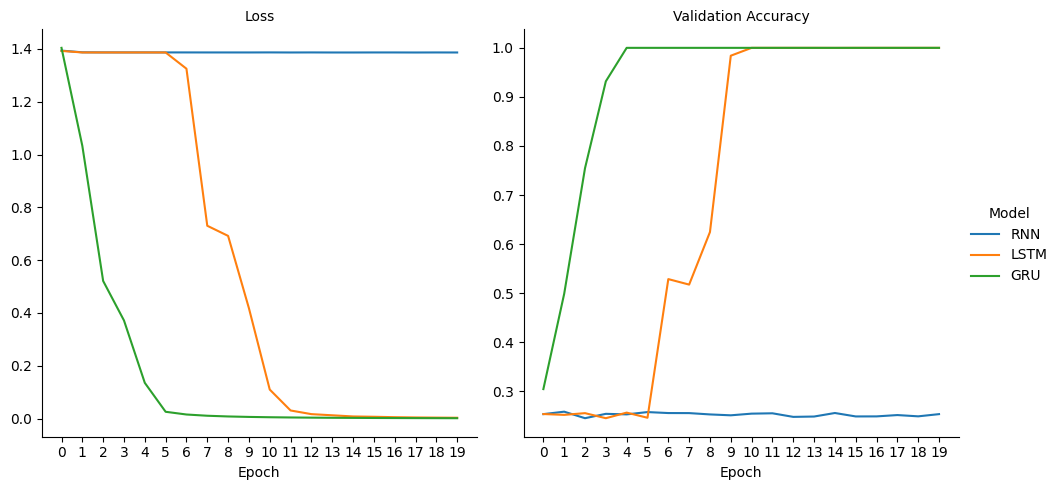

In [14]:
def to_frame(losses: list[float], accuracies: list[float]) -> pd.DataFrame:
    frame = pd.DataFrame(
        {
            "Epoch": np.arange(len(losses)),
            "Loss": losses,
            "Validation Accuracy": accuracies,
        }
    )
    frame = pd.melt(
        frame, id_vars=["Epoch"], var_name="Type", value_name="Value"
    )
    return frame


def plot_loss():
    frame_rnn = to_frame(losses_rnn, accuracies_rnn)
    frame_lstm = to_frame(losses_lstm, accuracies_lstm)
    frame_gru = to_frame(losses_gru, accuracies_gru)
    frame = pd.concat(
        {"RNN": frame_rnn, "LSTM": frame_lstm, "GRU": frame_gru},
        names=["Model"],
    )
    frame = frame.reset_index(level=0)
    grid = sns.relplot(
        frame,
        x="Epoch",
        col="Type",
        y="Value",
        hue="Model",
        facet_kws={"sharey": False},
        kind="line",
    )
    grid.set_titles(col_template="{col_name}")
    grid.set_axis_labels("Epoch", "")
    grid.set(xticks=list(range(frame["Epoch"].max() + 1)))


plot_loss()

Finally, we evaluate the models on the test set.

In [15]:
print(f'RNN Test Accuracy: {evaluate(rnn, testloader):.2%}')
print(f'LSTM Test Accuracy: {evaluate(lstm, testloader):.2%}')
print(f'GRU Test Accuracy: {evaluate(gru, testloader):.2%}')

RNN Test Accuracy: 25.76%
LSTM Test Accuracy: 100.00%
GRU Test Accuracy: 100.00%


## Remark (LSTM vs GRU)
GRU has less parameters than LSTM, but the two don't have the same performance for all cases. It is a well-known fact that either LSTM or GRU can have higher performance for a particular dataset. So we recommend you should use the two networks.

# Question (not mandatory to answer)
In this lab session, we delved into RNNs (Recurrent Neural Network) and observed the consequences of the gradient vanishing (or exploding) problem inherent in them. While LSTM and GRU have alleviated this problem to a significant extent.

However, have LSTM and GRU completely resolved this problem? Our answer is "not quite." While these architectures have indeed made substantial progress in mitigating the problem, it's not a guaranteed solution for all cases.

To overcome this challenge in RNNs, we need to explore further.\
Imagine for the answer